In [ ]:
HILBERTS TRANSFORM 

In [ ]:
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert

# ──────────────── Helpers ────────────────────────────

def bandpass_filter(data, sfreq, low, high, order=4):
    """Apply a 4th-order Butterworth bandpass between low–high Hz."""
    b, a = butter(order, [low/(sfreq/2), high/(sfreq/2)], btype='band')
    return filtfilt(b, a, data)

def calculate_band_presence(data, sfreq, bands):
    """
    For each band, filter the signal, compute its Hilbert amplitude
    envelope, threshold to detect 'presence', and return:
      - total presence time (s)
      - mean envelope amplitude
      - the filtered signal
    """
    results = {}
    for name, (low, high) in bands.items():
        filt = bandpass_filter(data, sfreq, low, high)
        env  = np.abs(hilbert(filt))
        thresh = 0.5 * np.std(env)
        presence = np.sum(env > thresh) / sfreq
        results[name] = {
            'presence_sec': presence,
            'avg_amplitude': np.mean(env),
            'filtered': filt
        }
    return results

def hilbert_analysis(data, sfreq):
    """Compute global Hilbert metrics: mean amplitude & mean instantaneous freq."""
    analytic = hilbert(data)
    env      = np.abs(analytic)
    phase    = np.unwrap(np.angle(analytic))
    inst_freq = np.diff(phase) / (2*np.pi) * sfreq
    return {
        'avg_amplitude': np.mean(env),
        'avg_frequency': np.mean(inst_freq),
        'envelope': env
    }

# ──────────────── Main Analysis ────────────────────────

# 1) Load your SC4822G0-PSG.edf file
file_path = os.path.join(os.getcwd(), "SC4822G0-PSG.edf")
raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)

# 2) Pick the Fpz-Cz channel and truncate to first 1000s
channel = "EEG Fpz-Cz"
raw.pick_channels([channel])
sfreq = raw.info['sfreq']

data_all, times_all = raw.get_data()[0], raw.times
n_keep = int(1000 * sfreq)
data_all = data_all[:n_keep]
times_all = times_all[:n_keep]

# 3) Define your segment: e.g., start=300s, duration=60s
start_sec = 300
duration  = 60
i0 = int(start_sec * sfreq)
i1 = i0 + int(duration * sfreq)
segment = data_all[i0:i1]
times   = times_all[i0:i1]

# 4) Frequency bands
bands = {
    "Delta": (0.5, 4),
    "Theta": (4,   8),
    "Alpha": (8,  12),
    "Beta":  (12, 30)
}

# 5) Compute band presence + Hilbert metrics
band_results    = calculate_band_presence(segment, sfreq, bands)
hilbert_results = hilbert_analysis(segment, sfreq)

# 6) Print a summary report
print("\n" + "="*60)
print(f"EEG Hilbert Analysis – Channel: {channel}")
print(f"Time Window: {start_sec}–{start_sec+duration} s")
print("="*60, "\n")

print(f"{'Band':<10}{'Presence (s)':>15}{'Avg Env Amp':>15}")
for b, vals in band_results.items():
    print(f"{b:<10}{vals['presence_sec']:>15.1f}{vals['avg_amplitude']:>15.4f}")

print("\nGlobal Hilbert Metrics:")
print(f"  Mean Envelope Amplitude: {hilbert_results['avg_amplitude']:.4f} µV")
print(f"  Mean Inst. Frequency:     {hilbert_results['avg_frequency']:.2f} Hz\n")

# 7) Visualization
fig, axs = plt.subplots(3, 1, figsize=(14, 10))

# Original
axs[0].plot(times, segment, 'k')
axs[0].set(title="Original EEG Signal", xlabel="Time (s)", ylabel="µV")
axs[0].grid(True)

# Band-filtered
for name, vals in band_results.items():
    axs[1].plot(times, vals['filtered'], label=name)
axs[1].set(title="Band-Filtered Signals", xlabel="Time (s)", ylabel="µV")
axs[1].legend(loc='upper right')
axs[1].grid(True)

# Hilbert envelope
axs[2].plot(times, hilbert_results['envelope'], 'r', label='Envelope')
axs[2].plot(times, segment, 'k', alpha=0.5, label='Original')
axs[2].set(title="Amplitude Envelope (Hilbert)", xlabel="Time (s)", ylabel="µV")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
SLEEP STAGE DIVISION 

Extracting EDF parameters from /Users/varunperi/Desktop/untitled folder/SleepEEGNet/data_2013/SC4171E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8225999  =      0.000 ... 82259.990 secs...


/var/folders/f0/4yb39bcj4s7d4nhykl584s680000gn/T/ipykernel_18042/1228587301.py:8: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)
/var/folders/f0/4yb39bcj4s7d4nhykl584s680000gn/T/ipykernel_18042/1228587301.py:8: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)
/var/folders/f0/4yb39bcj4s7d4nhykl584s680000gn/T/ipykernel_18042/1228587301.py:8: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


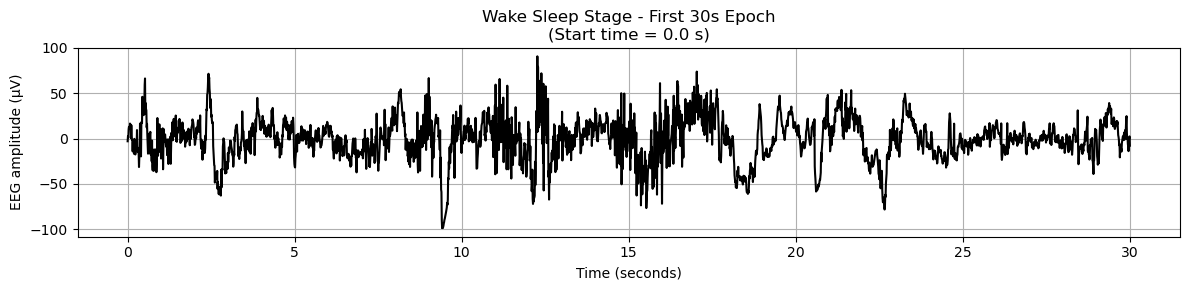

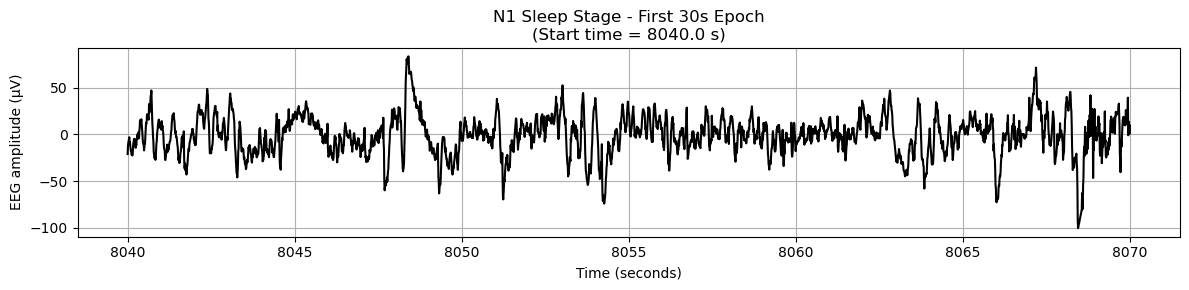

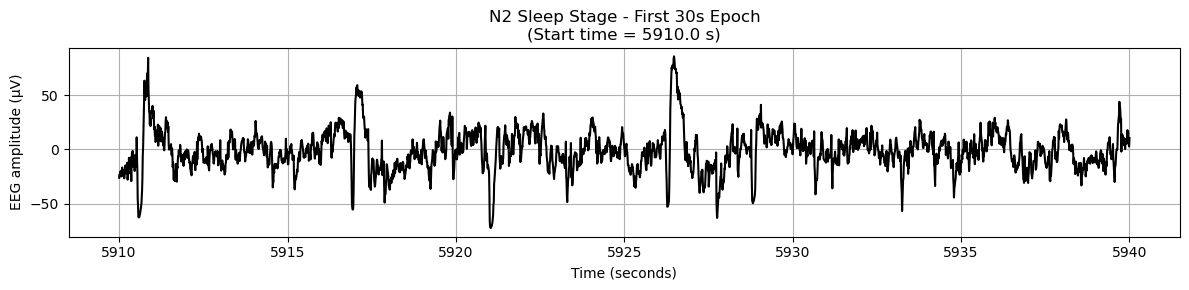

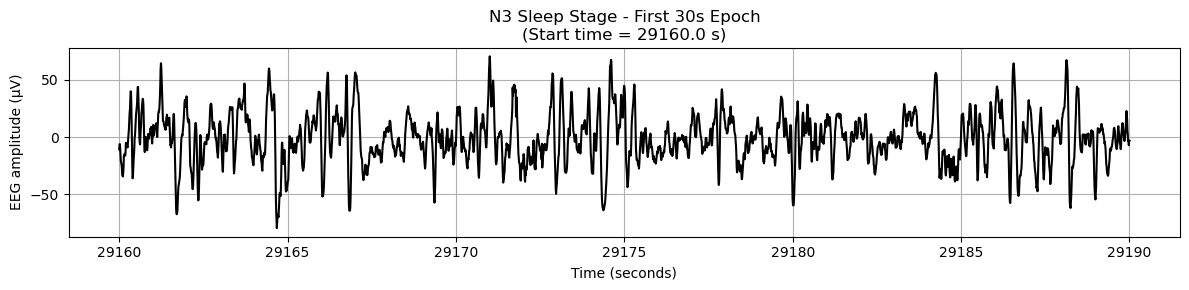

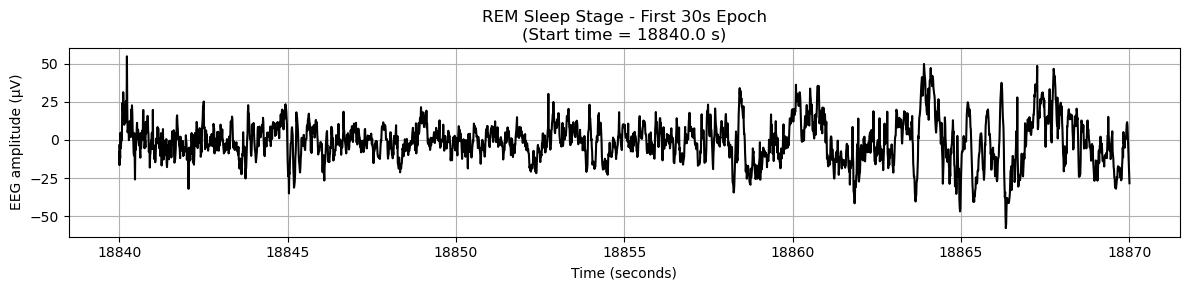

In [13]:
import mne
import yasa
import numpy as np
import matplotlib.pyplot as plt

# Load EDF file
file_path = "" #--------------> ENTER YOUR FOLDER PATH HERE 
raw = mne.io.read_raw_edf(file_path, preload=True)

eeg_ch = 'EEG Fpz-Cz'  # Choose your EEG channel
raw_ch = raw.copy().pick_channels([eeg_ch])

# Run sleep staging
slst = yasa.SleepStaging(raw_ch, eeg_name=eeg_ch)
hypno = slst.predict()
epoch_duration = 30  # seconds
sfreq = raw.info['sfreq']

# Sleep stage labels
stages = {'W': 'Wake', 'N1': 'N1', 'N2': 'N2', 'N3': 'N3', 'R': 'REM'}

for stage_code, stage_name in stages.items():
    # Find all epochs indices for this stage
    epoch_indices = np.where(hypno == stage_code)[0]
    if len(epoch_indices) == 0:
        print(f"No epochs found for stage {stage_name}")
        continue

    # Take only the first epoch for that stage
    idx = epoch_indices[0]

    start_sample = int(idx * epoch_duration * sfreq)
    stop_sample = int(start_sample + epoch_duration * sfreq)
    segment = raw_ch.get_data(start=start_sample, stop=stop_sample)[0]
    time = np.linspace(start_sample / sfreq, stop_sample / sfreq, len(segment))

    # Plot individual sleep stage epoch
    plt.figure(figsize=(12, 3))
    plt.plot(time, segment * 1e6, color='black')  # Convert to µV for readability
    plt.title(f'{stage_name} Sleep Stage - First 30s Epoch\n(Start time = {time[0]:.1f} s)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('EEG amplitude (µV)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
EEG CLASSIFICATION 

Extracting EDF parameters from /Users/varunperi/Desktop/untitled folder/SleepEEGNet/data_2013/SC4171E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8225999  =      0.000 ... 82259.990 secs...


/var/folders/f0/4yb39bcj4s7d4nhykl584s680000gn/T/ipykernel_18042/405582585.py:8: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)
/var/folders/f0/4yb39bcj4s7d4nhykl584s680000gn/T/ipykernel_18042/405582585.py:8: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)
/var/folders/f0/4yb39bcj4s7d4nhykl584s680000gn/T/ipykernel_18042/405582585.py:8: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


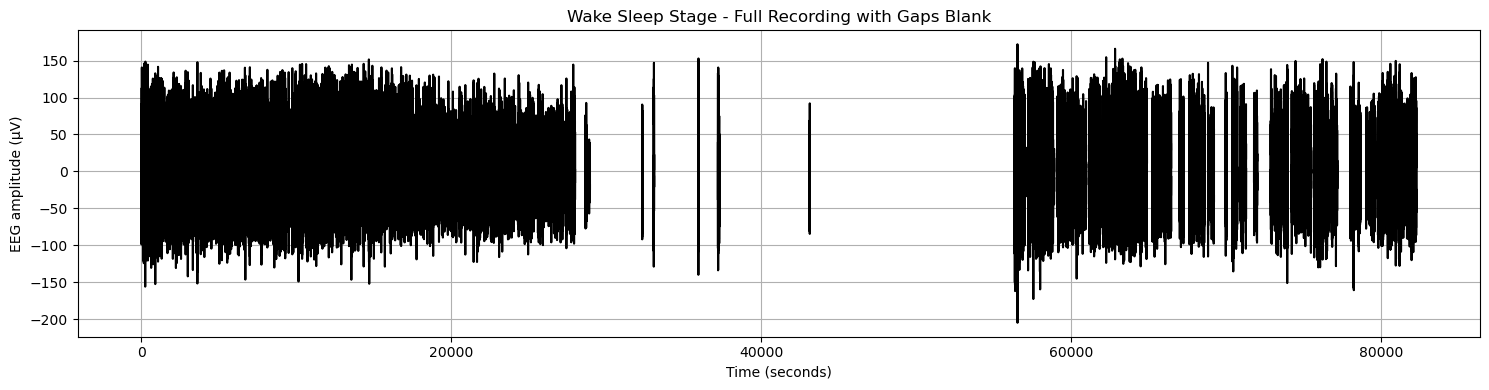

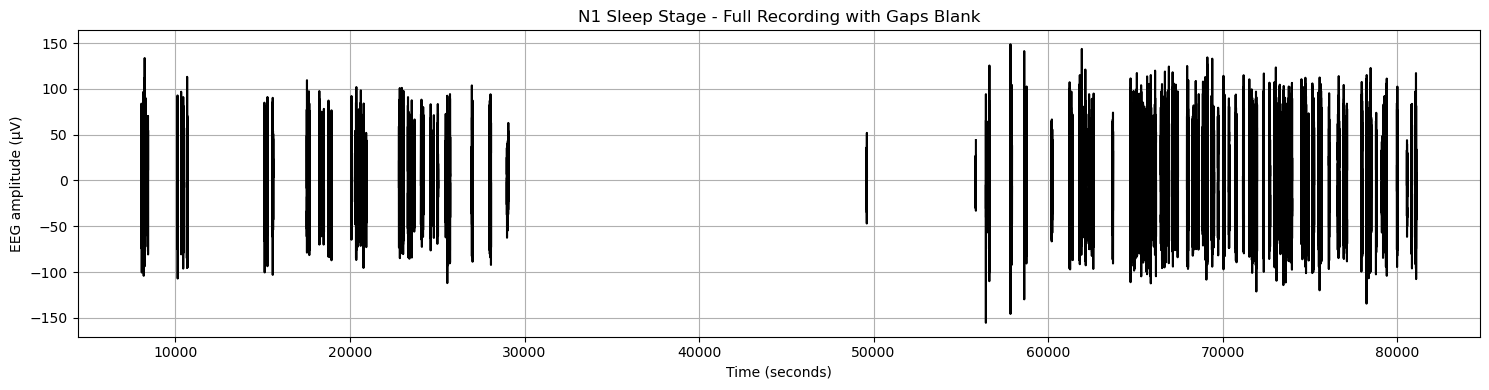

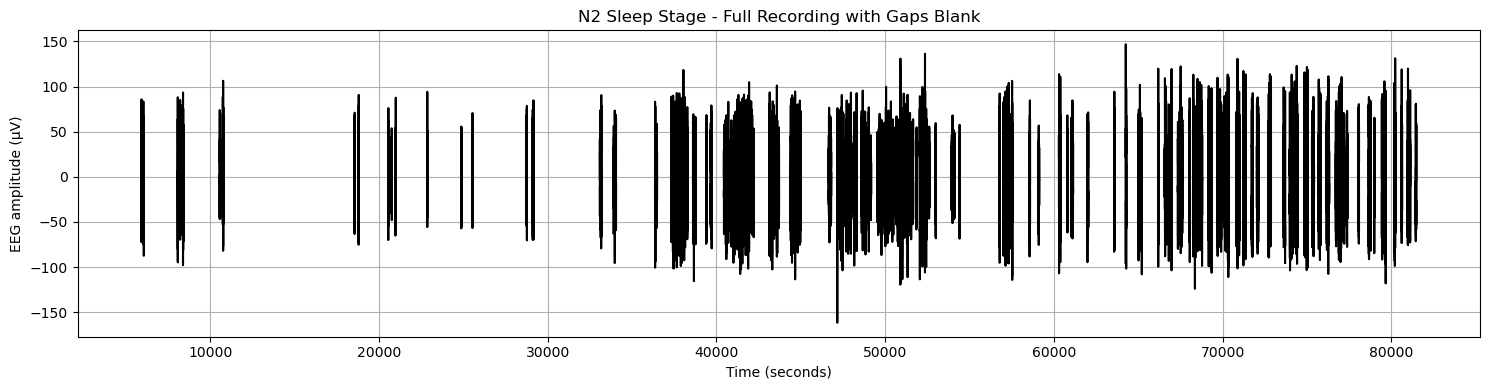

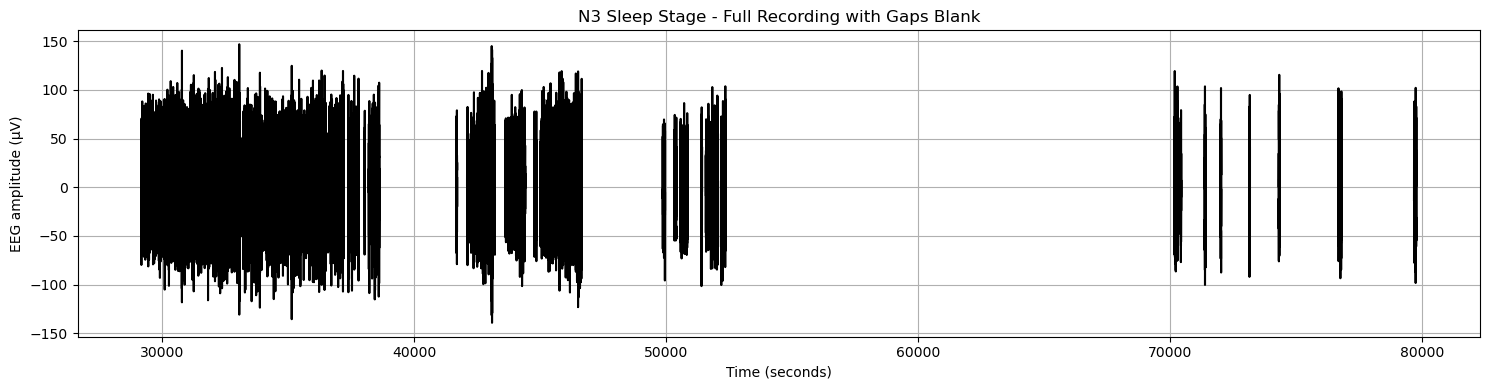

In [ ]:
import mne
import yasa
import numpy as np
import matplotlib.pyplot as plt

# Load EDF file
file_path = "" #--------------> ENTER YOUR FOLDER PATH HERE 
raw = mne.io.read_raw_edf(file_path, preload=True)

eeg_ch = 'EEG Fpz-Cz'  # Choose your EEG channel
raw_ch = raw.copy().pick_channels([eeg_ch])

# Run sleep staging
slst = yasa.SleepStaging(raw_ch, eeg_name=eeg_ch)
hypno = slst.predict()
epoch_duration = 30  # seconds
sfreq = raw.info['sfreq']

# Total number of samples in the recording
total_samples = raw_ch.n_times
total_time = total_samples / sfreq

# Sleep stage labels
stages = {'W': 'Wake', 'N1': 'N1', 'N2': 'N2', 'N3': 'N3', 'R': 'REM'}

for stage_code, stage_name in stages.items():
    # Find all epochs indices for this stage
    epoch_indices = np.where(hypno == stage_code)[0]
    if len(epoch_indices) == 0:
        print(f"No epochs found for stage {stage_name}")
        continue

    # Create array full length filled with NaNs (blank)
    stage_data = np.full(total_samples, np.nan)

    # Fill data only for epochs of this stage
    for idx in epoch_indices:
        start_sample = int(idx * epoch_duration * sfreq)
        stop_sample = int(start_sample + epoch_duration * sfreq)
        segment = raw_ch.get_data(start=start_sample, stop=stop_sample)[0]
        stage_data[start_sample:stop_sample] = segment

    # Time vector for full recording
    time = np.arange(total_samples) / sfreq

    plt.figure(figsize=(15, 4))
    plt.plot(time, stage_data * 1e6, color='black')  # µV scale
    plt.title(f'{stage_name} Sleep Stage - Full Recording with Gaps Blank')
    plt.xlabel('Time (seconds)')
    plt.ylabel('EEG amplitude (µV)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [ ]:
PSD AND HYPNOGRA GENERATION 


Processing EEG: SC4021E0-PSG.edf
Using Hypnogram: SC4021EH-Hypnogram.edf


/var/folders/f0/4yb39bcj4s7d4nhykl584s680000gn/T/ipykernel_4601/1451649003.py:83: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(os.path.join(data_folder, eeg_file), preload=True, verbose=False)
/var/folders/f0/4yb39bcj4s7d4nhykl584s680000gn/T/ipykernel_4601/1451649003.py:83: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(os.path.join(data_folder, eeg_file), preload=True, verbose=False)
/var/folders/f0/4yb39bcj4s7d4nhykl584s680000gn/T/ipykernel_4601/1451649003.py:83: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(os.path.join(data_folder, eeg_file), preload=True, verbose=False)
/var/folders/f0/4yb39bcj4s7d4nhykl584s680000gn/T/ipykernel_4601/1451649003.py:85: RuntimeWarning: Limited 1 annotation(s) that were expanding outsid

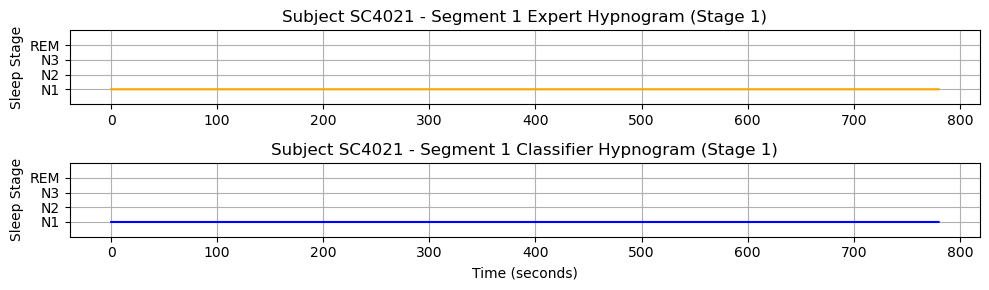

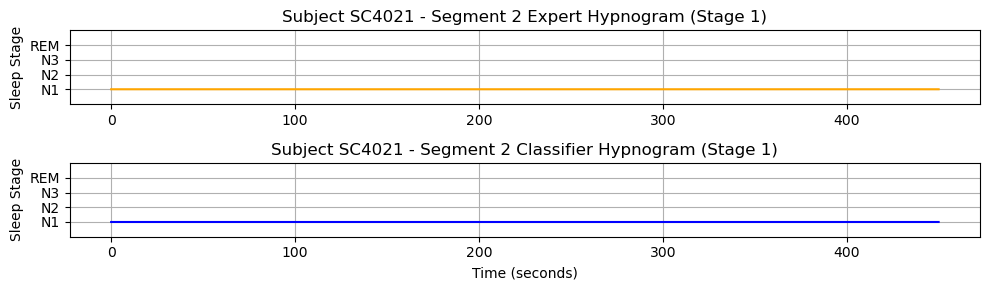

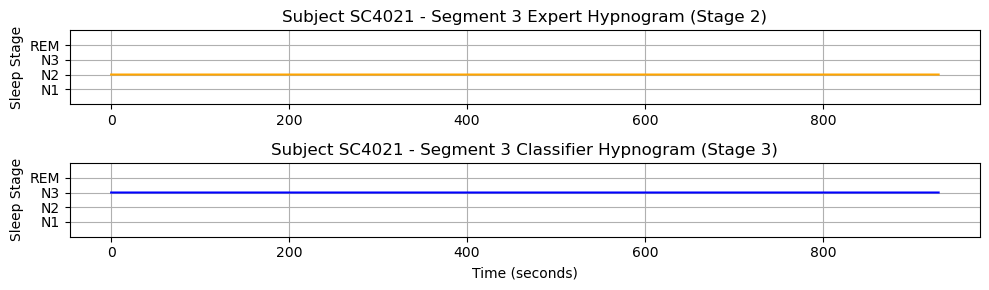

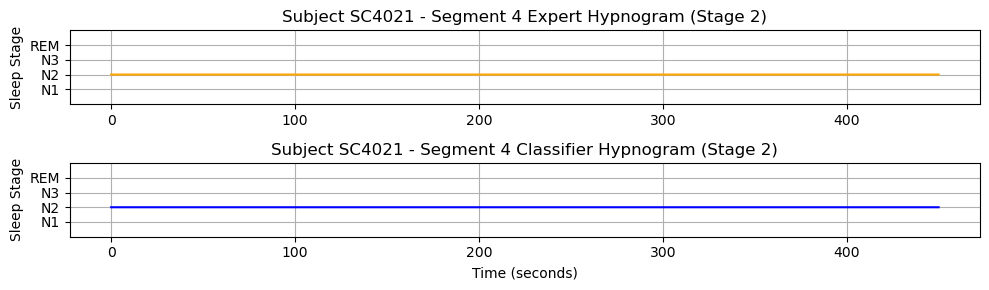

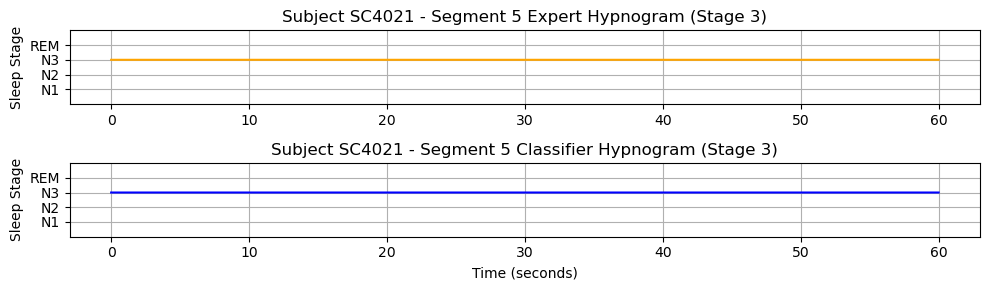


Processing EEG: SC4022E0-PSG.edf
Using Hypnogram: SC4022EJ-Hypnogram.edf


KeyboardInterrupt: 

In [1]:
import os
import glob
import numpy as np
import mne
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch, detrend
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# --- Classifier ---
def classify_sleep_stage(relative_alpha, relative_delta, relative_theta):
    band_ratio = relative_alpha / (relative_delta + relative_theta + 1e-8)
    if band_ratio > 0.45:
        return 'N1'
    elif band_ratio > 0.30:
        return 'REM'
    elif band_ratio > 0.21:
        return 'N2'
    elif 0.10 <= band_ratio <= 0.20:
        return 'N3'
    else:
        return 'Undefined'

# --- Bandpass filter ---
def butter_bandpass_filter(data, lowcut=3, highcut=20, fs=100, order=4):
    nyq = 0.5 * fs
    low, high = lowcut / nyq, highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# --- Compute band powers ---
def compute_band_powers(epoch, fs):
    f, psd = welch(epoch, fs=fs, window='hann', nperseg=4*fs, noverlap=2*fs)
    total_power = np.trapz(psd[(f >= 3) & (f <= 30)], f[(f >= 3) & (f <= 30)])

    bands = {'Delta': (3, 4), 'Theta': (4, 8), 'Alpha': (8, 12)}
    abs_powers = {}
    rel_powers = {}

    for band, (low, high) in bands.items():
        idx = (f >= low) & (f <= high)
        band_power = np.trapz(psd[idx], f[idx])
        abs_powers[band] = band_power
        rel_powers[band] = (band_power / total_power * 100) if total_power > 0 else 0

    return abs_powers, rel_powers

# --- Folder and file lists ---
data_folder = "" #--------------> ENTER YOUR FOLDER PATH HERE 

eeg_files = [
    "SC4021E0-PSG.edf",
    "SC4022E0-PSG.edf",
    "SC4031E0-PSG.edf",
    "SC4032E0-PSG.edf",
    "SC4041E0-PSG.edf"
]

label_map = {
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4
}

all_expert_labels = []
all_pred_labels = []
adjusted_expert = []
adjusted_pred = []

for eeg_file in eeg_files:
    eeg_prefix = eeg_file[:6]
    hyp_files = glob.glob(os.path.join(data_folder, f"{eeg_prefix}*Hypnogram*.edf"))
    if len(hyp_files) == 0:
        print(f"No hypnogram file found for {eeg_file}, skipping.")
        continue
    hyp_file = hyp_files[0]

    print(f"\nProcessing EEG: {eeg_file}")
    print(f"Using Hypnogram: {os.path.basename(hyp_file)}")

    raw = mne.io.read_raw_edf(os.path.join(data_folder, eeg_file), preload=True, verbose=False)
    annotations = mne.read_annotations(hyp_file)
    raw.set_annotations(annotations)
    raw.pick(['EEG Pz-Oz'])

    fs = int(raw.info['sfreq'])
    data = raw.get_data()[0] * 1e6

    sleep_segments = []
    sleep_labels = []
    for onset, duration, desc in zip(annotations.onset, annotations.duration, annotations.description):
        if desc in label_map:
            label = label_map[desc]
            if label == 0:
                continue
            sleep_segments.append((onset, duration))
            sleep_labels.append(label)

    results = []

    for onset, duration, expert_label in zip([seg[0] for seg in sleep_segments],
                                             [seg[1] for seg in sleep_segments],
                                             sleep_labels):
        start_sample = int(onset * fs)
        end_sample = int((onset + duration) * fs)
        if end_sample > len(data):
            end_sample = len(data)

        epoch = data[start_sample:end_sample]
        epoch = detrend(epoch)
        filtered_epoch = butter_bandpass_filter(epoch, lowcut=3, highcut=20, fs=fs)

        abs_powers, rel_powers = compute_band_powers(filtered_epoch, fs)
        band_ratio = rel_powers['Alpha'] / (rel_powers['Delta'] + rel_powers['Theta'] + 1e-8)
        classifier_stage_str = classify_sleep_stage(rel_powers['Alpha'], rel_powers['Delta'], rel_powers['Theta'])
        classifier_stage = {'Wake': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'REM': 4, 'Undefined': -1}.get(classifier_stage_str, -1)

        if classifier_stage != -1:
            all_expert_labels.append(expert_label)
            all_pred_labels.append(classifier_stage)

            # Adjusted logic: if expert and pred are N2 or N3, treat as match
            if (expert_label in [2, 3] and classifier_stage in [2, 3]) or (expert_label == classifier_stage):
                adjusted_expert.append(expert_label)
                adjusted_pred.append(expert_label)
            else:
                adjusted_expert.append(expert_label)
                adjusted_pred.append(classifier_stage)

        results.append({
            'expert_label': expert_label,
            'predicted_label': classifier_stage,
            'band_ratio': band_ratio,
            'duration': duration,
            'onset': onset
        })

    num_to_plot = min(5, len(results))
    for i in range(num_to_plot):
        res = results[i]
        onset = res['onset']
        duration = res['duration']
        expert_stage = res['expert_label']
        pred_stage = res['predicted_label']

        start_sample = int(onset * fs)
        end_sample = int((onset + duration) * fs)
        if end_sample > len(data):
            end_sample = len(data)

        segment_time = np.linspace(0, duration, end_sample - start_sample)

        expert_hyp = np.full_like(segment_time, expert_stage)
        pred_hyp = np.full_like(segment_time, pred_stage)

        plt.figure(figsize=(10, 3))
        plt.subplot(2, 1, 1)
        plt.step(segment_time, expert_hyp, where='post', color='orange')
        plt.title(f'Subject {eeg_prefix} - Segment {i+1} Expert Hypnogram (Stage {expert_stage})')
        plt.ylabel('Sleep Stage')
        plt.yticks([1, 2, 3, 4], ['N1', 'N2', 'N3', 'REM'])
        plt.ylim(0, 5)
        plt.grid(True)

        plt.subplot(2, 1, 2)
        plt.step(segment_time, pred_hyp, where='post', color='blue')
        plt.title(f'Subject {eeg_prefix} - Segment {i+1} Classifier Hypnogram (Stage {pred_stage})')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Sleep Stage')
        plt.yticks([1, 2, 3, 4], ['N1', 'N2', 'N3', 'REM'])
        plt.ylim(0, 5)
        plt.grid(True)

        plt.tight_layout()
        plt.show()

# --- Original Accuracy ---
overall_accuracy = accuracy_score(all_expert_labels, all_pred_labels)
print(f"\nOriginal Accuracy: {overall_accuracy * 100:.2f}%")

labels = [1, 2, 3, 4]
names = ['N1', 'N2', 'N3', 'REM']

cm = confusion_matrix(all_expert_labels, all_pred_labels, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names)

plt.figure(figsize=(7, 5))
disp.plot(cmap='Blues')
plt.title("Original Confusion Matrix")
plt.show()

# --- Adjusted Accuracy (N2/N3 swaps allowed) ---
adjusted_accuracy = accuracy_score(adjusted_expert, adjusted_pred)
print(f"\nAdjusted Accuracy (N2/N3 swaps correct): {adjusted_accuracy * 100:.2f}%")

cm_adjusted = confusion_matrix(adjusted_expert, adjusted_pred, labels=labels)
disp_adj = ConfusionMatrixDisplay(confusion_matrix=cm_adjusted, display_labels=names)

plt.figure(figsize=(7, 5))
disp_adj.plot(cmap='Greens')
plt.title("Adjusted Confusion Matrix (N2/N3 swaps allowed)")
plt.show()

# --- Adjusted Hypnogram (Full) ---
# --- Expert Hypnogram ---
plt.figure(figsize=(14, 2.5))
plt.step(np.arange(len(adjusted_expert)), adjusted_expert, where='mid', color='orange')
plt.title("Expert Hypnogram")
plt.xlabel("Epoch Index")
plt.ylabel("Sleep Stage")
plt.yticks([1, 2, 3, 4], ['N1', 'N2', 'N3', 'REM'])
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Predicted Hypnogram (Adjusted) ---
plt.figure(figsize=(14, 2.5))
plt.step(np.arange(len(adjusted_pred)), adjusted_pred, where='mid', color='blue')
plt.title("Predicted Hypnogram (Adjusted Accuracy Interpretation)")
plt.xlabel("Epoch Index")
plt.ylabel("Sleep Stage")
plt.yticks([1, 2, 3, 4], ['N1', 'N2', 'N3', 'REM'])
plt.grid(True)
plt.tight_layout()
plt.show()

